<a href="https://colab.research.google.com/github/Isak-Petrin/distributional_RL_python/blob/main/Welcome_to_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gymnasium
!pip install pygame

In [42]:
from enum import Enum
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
from gymnasium.envs.registration import register
import math

class RandomWalk(gym.Env):
    def __init__(
        self,
        param: dict | None = None,
      ):
        self.l = 7
        self.start = self.l // 2
        self.observation_space = gym.spaces.Discrete(self.l)
        self.action_space = gym.spaces.Discrete(2)

    def _get_obs(self):
        return self.state
    def _get_info(self):
        return {'l': self.l}


    def reset(self,seed=None, options=None):
        self.state = self.start
        obs = self._get_obs()
        info = self._get_info()
        return obs,info

    def step(self, action: int):

      # store current observation as obs (pre-transition)
      obs = self._get_obs()

      # default settings
      self.done = False
      reward = 0

      # transition
      if action:
          self.state += 1
      else:
          self.state -= 1

      # clamp or check terminal
      if self.state == 0:
          self.done = True
          reward = np.random.normal(loc=2, scale = 0.5)
      elif self.state == self.l-1:
          self.done = True
          reward = np.random.normal(loc=4, scale = 0.5)
      next_obs = self._get_obs()
      info = self._get_info()

    # return obs and next_obs explicitly
      return obs, next_obs, reward, self.done, False, info




In [43]:
import gymnasium as gym
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

class O_CatTD:
    def __init__(
        self,
        env: gym.Env,
        alpha: float,
        theta_range: list[int,int],
        resolution: int,
        policy: int,
        gamma: float,
    ):
        self.alpha = alpha
        self.gamma = gamma
        self.env = env
        self.min_theta = theta_range[0]
        self.max_theta = theta_range[1]
        self.resolution = resolution
        self.theta_lst = np.linspace(self.min_theta, self.max_theta, resolution)
        self.m = len(self.theta_lst)
        self.p = [np.ones(self.m) * (1/self.m) for _ in range(self.env.observation_space.n)]
        self.policy = policy
        self.plot_lst = [np.array(copy.deepcopy(self.p))]
        self.t = 0
        self.k = 1e-6


    def find_i_star(self,g):
        bool_lst = self.theta_lst <= g
        i_star = np.where(bool_lst)[0].max()
        return i_star

    def get_alpha(self):
      return self.alpha / (1 + self.k * self.t)


    def learn_distribution(self, n_episodes: int):
        for episode in tqdm(range(n_episodes)):

            obs, info = self.env.reset()

            done = False

            t = 0
            while not done:
                a = np.random.randint(2)
                p_tilde = np.zeros(self.m, dtype=np.float64)
                s, sn, reward, done, _ , info, = self.env.step(a)
                for j in range(self.m):
                    if done:
                        g = reward
                    else:
                        g = reward + self.gamma * self.theta_lst[j]
                    if g <= self.min_theta:
                        p_tilde[0] += self.p[sn][j]
                    elif g >= self.max_theta:
                        p_tilde[self.m - 1] += self.p[sn][j]
                    else:
                        i_star = self.find_i_star(g)
                        zeta = (g - self.theta_lst[i_star]) / (self.theta_lst[i_star + 1] - self.theta_lst[i_star])
                        p_tilde[i_star] += (1-zeta) * self.p[sn][j]
                        p_tilde[i_star + 1] += zeta * self.p[sn][j]


                for i in range(self.m):
                    self.p[s][i] = (1 - self.alpha) * self.p[s][i] + self.alpha * p_tilde[i]

            self.plot_lst.append(np.array(copy.deepcopy(self.p)))
            self.t += 1






toy_env = RandomWalk()

catTD2 = O_CatTD(env = toy_env, alpha = 1e-3,theta_range=[-2,8],resolution = 50, policy = 1, gamma=1)
catTD2.learn_distribution(25000)



100%|██████████| 25000/25000 [01:40<00:00, 248.47it/s]


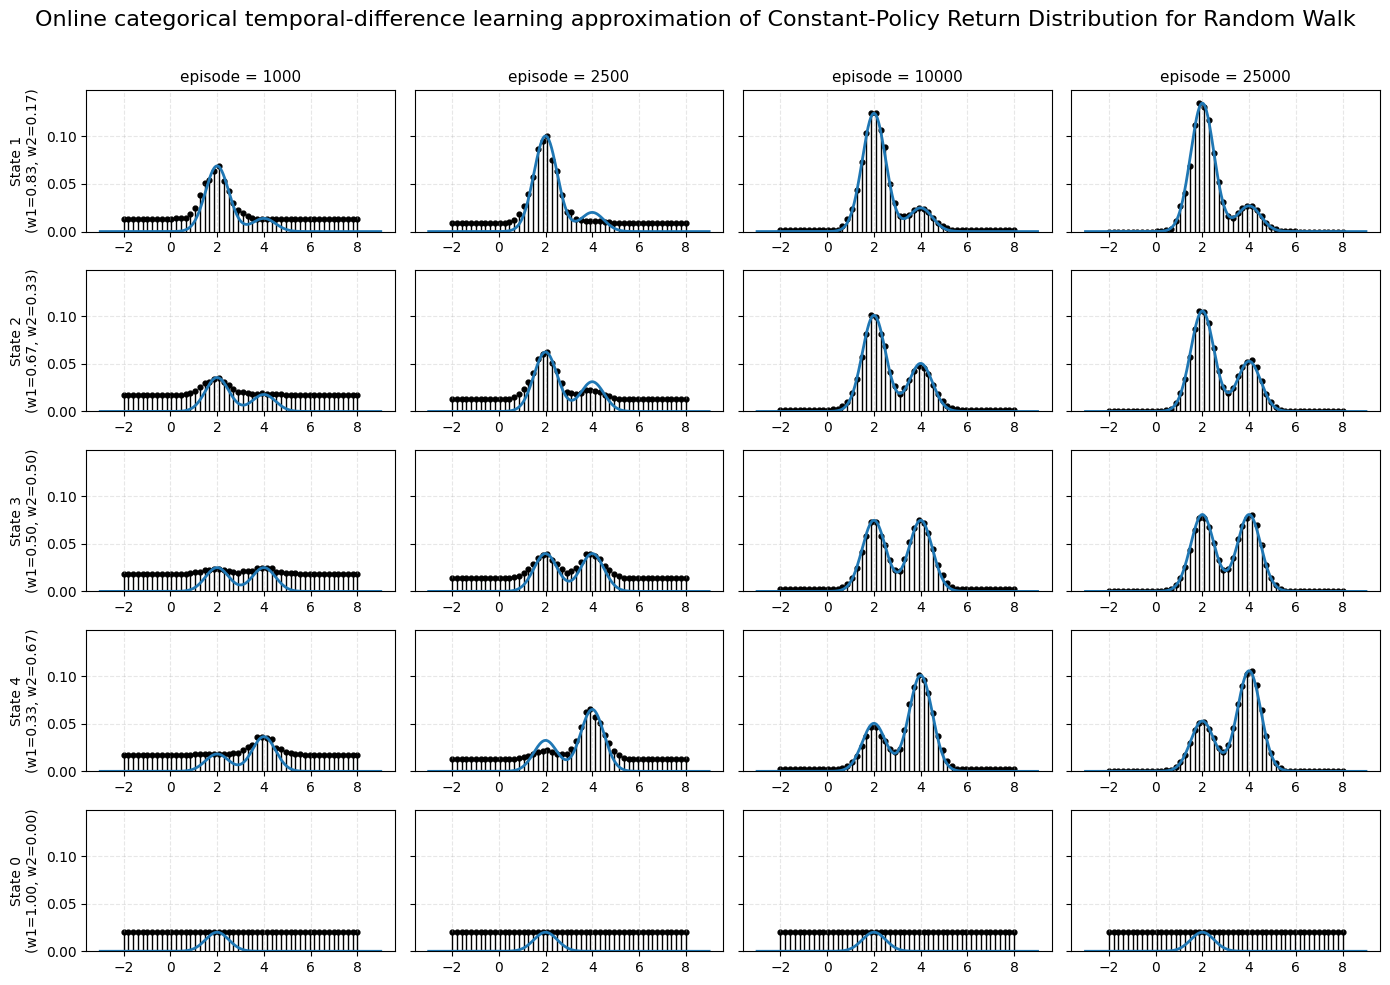

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_all_states_over_time(
    locations,
    plot_lst,
    states,             # e.g. [1,2,3,4,5]
    timesteps,          # e.g. [1000, 5000, 20000, 25000]
    mu_left, sigma_left,
    mu_right, sigma_right,
    n_points=400,
    figsize=(14, 10)
):

    locations = np.asarray(locations)

    # Precompute x-range
    xs = np.linspace(min(locations)-1, max(locations)+1, n_points)

    # Global y-scaling across all states & timesteps
    global_max = max(
        np.max(plot_lst[t][s])
        for s in states
        for t in timesteps
    )
    y_max = global_max * 1.1

    fig, axes = plt.subplots(
        len(states), len(timesteps),
        figsize=figsize,
        sharey=True
    )

    for row_idx, s in enumerate(states):

        # ---- Compute weights for this state ----
        # state 1 → w1=5/6
        # state 5 → w1=1/6
        w1 = (6 - s) / 6      # decreasing
        w2 = s / 6            # increasing

        # Precompute mixture for this state
        f1 = norm.pdf(xs, loc=mu_left,  scale=sigma_left)
        f2 = norm.pdf(xs, loc=mu_right, scale=sigma_right)
        mixture_raw = w1 * f1 + w2 * f2

        for col_idx, t in enumerate(timesteps):

            ax = axes[row_idx][col_idx]
            heights = np.asarray(plot_lst[t][s])

            # Scale mixture to spike amplitude
            mixture = mixture_raw * (max(heights) / max(mixture_raw))

            # Dirac spikes
            ax.vlines(locations, 0, heights, color='black', linewidth=1.0)
            ax.scatter(locations, heights, color='black', s=12)

            # Mixture curve
            ax.plot(xs, mixture, linewidth=2)

            # Labels
            if col_idx == 0:
                ax.set_ylabel(f"State {s}\n(w1={w1:.2f}, w2={w2:.2f})", fontsize=10)

            if row_idx == 0:
                ax.set_title(f"episode = {t}", fontsize=11)

            ax.grid(True, linestyle='--', alpha=0.3)
            ax.set_ylim(0, y_max)

    fig.suptitle("Online categorical temporal-diﬀerence learning approximation of Constant-Policy Return Distribution for Random Walk", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    fig = plt.gcf()  # get current figure
    fig.savefig("C51_constant_policy_grid.pdf", bbox_inches="tight")

    plt.show()



# ---- RUN IT ----

states = [1, 2, 3, 4, 0]
timesteps = [1000, 2500, 10000, 25000]

plot_all_states_over_time(
    locations=catTD2.theta_lst,
    plot_lst=catTD2.plot_lst,
    states=states,
    timesteps=timesteps,
    mu_left=2, sigma_left=1/2,
    mu_right=4, sigma_right=1/2
)


In [59]:
w = catTD2.theta_lst
mu_lst = []
for s in range(1,6):
  mu_lst.append(sum([a*b for a,b in zip(w,catTD2.p[s])]))
var_lst = []
for s in range(1,6):
  var_lst.append(sum([b*(a - mu_lst[s-1])**2 for a,b in zip(w,catTD2.p[s])]))

In [60]:
var_lst

[np.float64(0.8395503573843383),
 np.float64(1.1777693900516013),
 np.float64(1.2783654969753113),
 np.float64(1.1546136590646614),
 np.float64(0.8334508003809831)]

In [61]:
w = catTD.theta_lst
p = catTD.plot_lst[200000]
mu_lst = []
for s in range(1,6):
  mu_lst.append(sum([a*b for a,b in zip(w,p[s])]))
var_lst = []
for s in range(1,6):
  var_lst.append(sum([b*(a - mu_lst[s-1])**2 for a,b in zip(w,p[s])]))

In [66]:
var_lst

[np.float64(1.3394846883690221),
 np.float64(0.3452080199263771),
 np.float64(0.31729444115772865),
 np.float64(0.30391852439885136),
 np.float64(0.2915416883693704)]

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.signal import savgol_filter
class quantile:
    def __init__(self, m: int):
        self.m = m
        self.theta = np.linspace(-2,2,self.m)

    def get_theta(self):
        return self.theta
    def set_theta(self,theta):
        self.theta = theta
    def add_theta(self, diff):
        self.theta += diff
    def sample(self):
        return np.random.choice(self.theta)
    def mean(self):
        return np.mean(self.theta)

class container:
    def __init__(self, x0):
        self.hist = []
        self.xs = [x0]
        self.rs = []
        self.ds = []

    def add(self, obs: tuple):
        self.hist.append(obs)
        self.xs.append(obs[0])
        self.rs.append(obs[1])
        self.ds.append(obs[2])

    def get_xs(self):
        return self.xs
    def get_rs(self):
        return self.rs
    def get_x(self,t):
        return self.xs[t]
    def get_d(self,t):
        return self.ds[t]

    def reset(self, x0):
        self.hist = []
        self.xs = [x0]
        self.rs = []
        self.ds = []


class QRTDlAgent:
    def __init__(self, m: int, l: float ,obs_space: int, gamma: float, alpha: float, x0, bootstrap: bool, kappa: bool):
        self.m = m
        self.l = l
        self.bootstrap = bootstrap
        self.q = {x: quantile(m = self.m) for x in range(obs_space)}
        self.tau = np.asarray([(2*i - 1) / (2*self.m) for i in range(1,self.m+1)])
        self.gamma = gamma
        self.N = {x: 0 for x in range(obs_space)}
        self.container = container(x0=x0)
        self.trace = lambda s: (1 - self.l) * self.l**(s - 1)
        self.t = 0
        self.alpha0 = alpha
        self.episode = 0
        self.kappa = kappa

    def reset(self,x0):
        self.t = 0
        self.episode += 1
        self.container.reset(x0)
    def get_mean(self,x):
        return self.q[x].mean()
    def get_xs(self):
        return self.container.get_xs()

    def get_ds(self,t):
        return self.container.get_d(t)

    def get_q(self, x):
        return self.q[x]
    def get_xt(self,t):
        x = self.container.get_x(t = t)
        return x,self.q[x].get_theta()

    def _huber_grad(self, u):
        k = float(self.kappa)  # ensure numeric
        return np.where(np.abs(u) <= k, u / k, np.sign(u))


    def get_alpha(self, x, trc):
        # either do not mutate N here...
        eff_visits = self.N[x] + trc
        alpha_x = self.alpha0 / ((1.0 + eff_visits) ** 0.8)
        return max(alpha_x, 1e-4)


    def get_theta(self, x):
        return self.q[x].get_theta()

    def add_diff(self, x, diff):
        self.q[x].add_theta(diff)

    def get_tau(self):
        return self.tau

    def project_monotone(self, x):
        theta = self.q[x].get_theta()
        theta = np.maximum.accumulate(theta)
        self.q[x].set_theta(theta)

    def store(self,x,r, done):
        self.container.add((x,r,done))

    def update(self, x, x_n, r, done: bool):
        x = x_n
        self.t += 1

        self.store(x, r, done)

        for i in range(self.t):
            h = self.t - i
            target = self.get_target(t=i, h=h)          # scalar if bootstrap else vector (len m)
            x_i, theta = self.get_xt(t=i)               # theta shape: (m,)
            xs = self.get_xs()
            adj = 1

            if xs.count(x_i) >= 2:
                if i != (len(xs)-1 -xs[::-1].index(x_i)):
                    continue

            #if xs.count(x_i) >= 2:
            #    adj = xs.count(x_i)
            #if xs.count(x_i) >= 2:
            #    if i != (xs.index(x_i)):
            #        continue

            trc   = self.trace(s=h)
            alpha = self.get_alpha(x=x_i, trc=trc)

            if self.bootstrap:
                # target is scalar -> deltas per quantile
                delta = target - theta                  # shape: (m,)
                weight = np.abs(self.tau - (delta < 0).astype(float))  # |tau - 1{delta<0}|
                g = weight * self._huber_grad(delta)    # elementwise
                grad = alpha * trc * g                  # optional: / self.m for stability
            else:
                delta = target[None, :] - theta[:, None]                       # (m, m)
                weight = np.abs(self.tau[:, None] - (delta < 0).astype(float)) # (m, m)
                g = weight * self._huber_grad(delta)                           # (m, m)
                grad = self.alpha0 * trc * g.mean(axis=1)                          # average over j -> (m,)

            self.add_diff(x=x_i, diff= grad)


    def get_target(self, t,h):
        rs = self.container.get_rs()
        xb = self.container.get_x(t = t+h)
        if self.bootstrap:
            target = 0
            for i,k in enumerate(range(t,t+h)):
                target += self.gamma**i * rs[k]
                if self.get_ds(t = k) == True:
                    return target
            return target + self.q[xb].sample() * self.gamma**h
        else:
            target = np.zeros(self.m)
            for i,k in enumerate(range(t,t+h)):
                target += self.gamma**i * np.ones(self.m) * rs[k]
                if self.get_ds(t = k) == True:
                    return target
            return target + self.get_theta(xb) * self.gamma**h


In [ ]:
G = 0
for i in range(7):
  G += -0.1 * 0.95**i

G + 20 * 0.95**7

13.363420514062495

<>:52: SyntaxWarning: invalid escape sequence '\l'
<>:52: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1337022246.py:52: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(range(episodes), vs[agent], label=f'$\lambda$ = {agent.l}')
100%|██████████| 25000/25000 [09:06<00:00, 45.76it/s]


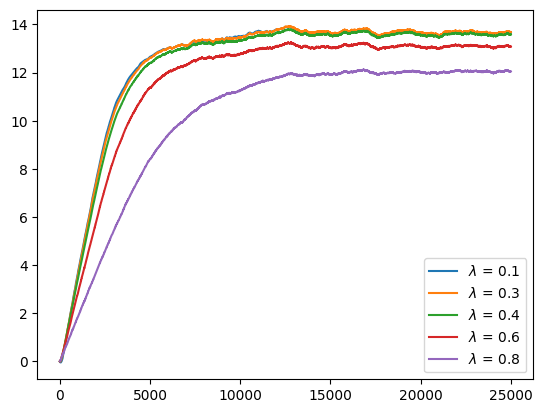

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import sys


episodes = 25000
gamma = 0.95
alpha = 0.05
length = 7
bootstrap = False
x0 = 2
m = 15
kappa = 2

agent1 = QRTDlAgent(m = m,obs_space=length,l = .1 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent2 = QRTDlAgent(m = m,obs_space=length,l = .3 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent3 = QRTDlAgent(m = m,obs_space=length,l = .4 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent4 = QRTDlAgent(m = m,obs_space=length,l = .6 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent5 = QRTDlAgent(m = m,obs_space=length,l = .8 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)


agents = [agent1,agent2,agent3, agent4, agent5]

env = RandomWalk()
vs = {agent: [] for agent in agents}

for episode in tqdm(range(episodes)):
    obs, _ = env.reset()
    for agent in agents:
        vs[agent].append(agent.q[3].theta.mean())
        agent.reset(x0 = obs)

    done = False
    prev = length // 2
    while not done:
        action = np.random.randint(2)
        info = env.step(action)

        obs = info[0]
        reward = info[1]
        done = info[2]

        for agent in agents:
            agent.update(x_n=obs,x=prev, r = reward, done = done)
        prev = obs



for agent in agents:
    plt.plot(range(episodes), vs[agent], label=f'$\lambda$ = {agent.l}')
plt.legend()
plt.show()


In [ ]:
agent1.q[3].theta

array([10.55531054, 11.06590604, 11.40123588, 11.68302715, 11.94329689,
       12.22345887, 12.51105126, 12.83119462, 13.21180896, 13.65739179,
       14.1989751 , 14.81411197, 15.4317169 , 16.0655693 , 16.92494612])

<>:52: SyntaxWarning: invalid escape sequence '\l'
<>:52: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-295618120.py:52: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(range(episodes), vs[agent], label=f'$\lambda$ = {agent.l}')
100%|██████████| 10000/10000 [05:46<00:00, 28.88it/s]


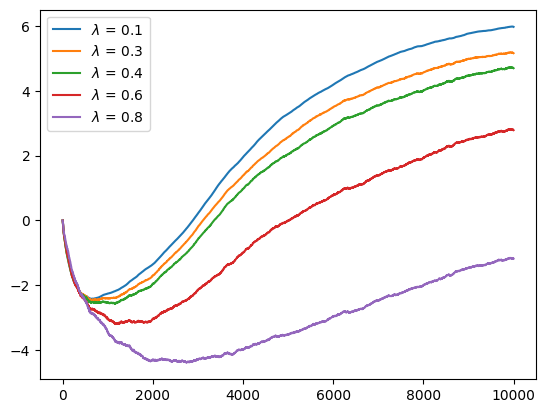

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import sys


episodes = 10000
gamma = 0.95
alpha = 0.05
length = 7
bootstrap = False
x0 = 2
m = 10
kappa = 1

agent1 = QRTDlAgent(m = m,obs_space=length,l = .1 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent2 = QRTDlAgent(m = m,obs_space=length,l = .3 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent3 = QRTDlAgent(m = m,obs_space=length,l = .4 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent4 = QRTDlAgent(m = m,obs_space=length,l = .6 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)
agent5 = QRTDlAgent(m = m,obs_space=length,l = .8 ,gamma = gamma, alpha = alpha, x0 = x0, bootstrap=bootstrap, kappa = kappa)


agents = [agent1,agent2,agent3, agent4, agent5]

env = RandomWalk()
vs = {agent: [] for agent in agents}

for episode in tqdm(range(episodes)):
    obs, _ = env.reset()
    for agent in agents:
        vs[agent].append(agent.q[3].mean())
        agent.reset(x0 = obs)

    done = False
    prev = length // 2
    while not done:
        action = np.random.randint(2)
        info = env.step(action)

        obs = info[0]
        reward = info[1]
        done = info[2]

        for agent in agents:
            agent.update(x_n=obs,x=prev, r = reward, done = done)
        prev = obs



for agent in agents:
    plt.plot(range(episodes), vs[agent], label=f'$\lambda$ = {agent.l}')
plt.legend()
plt.show()


In [ ]:
import gymnasium as gym
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

class O_CatTD:
    def __init__(
        self,
        env: gym.Env,
        alpha: float,
        theta_range: list[int,int],
        resolution: int,
        policy: int,
        gamma: float,
    ):
        self.alpha = alpha
        self.gamma = gamma
        self.env = env
        self.min_theta = theta_range[0]
        self.max_theta = theta_range[1]
        self.resolution = resolution
        self.theta_lst = np.linspace(self.min_theta, self.max_theta, resolution)
        self.m = len(self.theta_lst)
        self.p = [np.ones(self.m) * (1/self.m) for _ in range(self.env.observation_space.n)]
        self.policy = policy
        self.plot_lst = [np.array(copy.deepcopy(self.p))]
        self.t = 0
        self.k = 1e-6

    def mu(self,s):
        return sum([a*b for a,b in zip(self.theta_lst,self.p[s])])

    def find_i_star(self,g):
        bool_lst = self.theta_lst <= g
        i_star = np.where(bool_lst)[0].max()
        return i_star

    def get_alpha(self):
      return self.alpha / (1 + self.k * self.t)


    def learn_distribution(self, n_episodes: int):
        for episode in tqdm(range(n_episodes)):

            s, info = self.env.reset()
            done = False
            t = 0
            alpha = self.get_alpha()
            while not done:
                eps = np.random.random()
                if eps < 0.05:
                    a = np.random.randint(2)
                else:
                  if self.mu(s+1) > self.mu(s-1):
                      a = 1
                  else:
                      a = 0
                t += 1
                p_tilde = np.zeros(self.m, dtype=np.float64)
                s, sn, reward, done, _ , info, = self.env.step(a)
                for j in range(self.m):
                    if done:
                        g = reward
                    else:
                        g = reward + self.gamma * self.theta_lst[j]
                    if g <= self.min_theta:
                        p_tilde[0] += self.p[sn][j]
                    elif g >= self.max_theta:
                        p_tilde[self.m - 1] += self.p[sn][j]
                    else:
                        i_star = self.find_i_star(g)
                        zeta = (g - self.theta_lst[i_star]) / (self.theta_lst[i_star + 1] - self.theta_lst[i_star])
                        p_tilde[i_star] += (1-zeta) * self.p[sn][j]
                        p_tilde[i_star + 1] += zeta * self.p[sn][j]


                for i in range(self.m):
                    self.p[s][i] = (1 - alpha) * self.p[s][i] + alpha * p_tilde[i]


            if episode % 1000 == 0:
              self.plot_lst.append(np.array(self.p))  # no deepcopy; see next point
            self.t += 1






toy_env = RandomWalk()

catTD = O_CatTD(env = toy_env, alpha = 1e-3,theta_range=[-2,8],resolution = 50, policy = 1, gamma=1)
catTD.learn_distribution(500000)



 29%|██▉       | 145035/500000 [04:47<26:43, 221.35it/s]

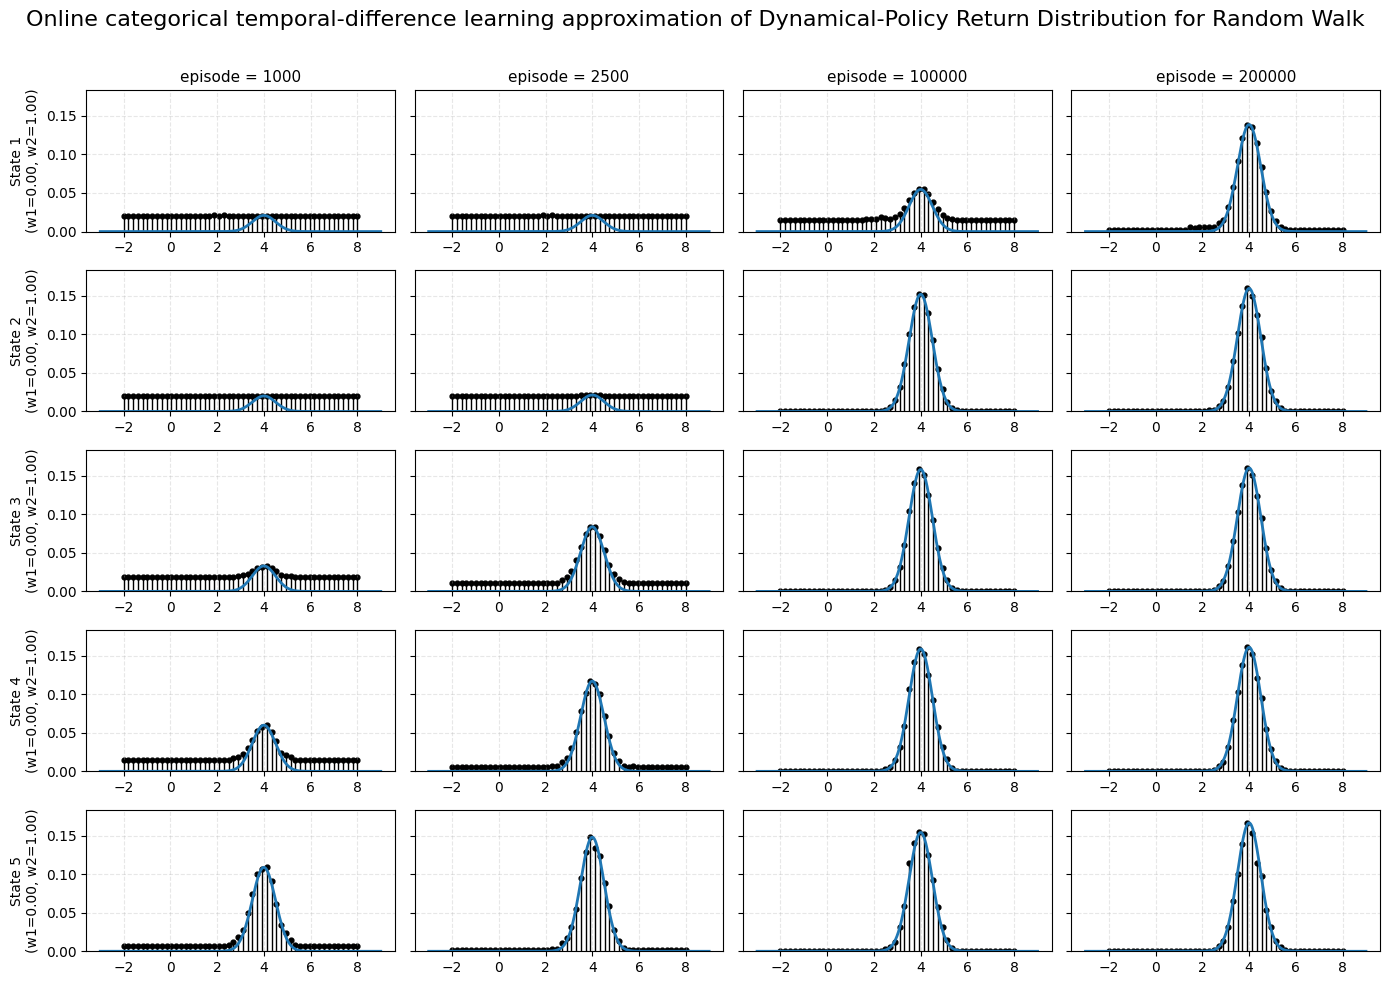

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_all_states_over_time(
    locations,
    plot_lst,
    states,             # e.g. [1,2,3,4,5]
    timesteps,          # e.g. [1000, 5000, 20000, 25000]
    mu_left, sigma_left,
    mu_right, sigma_right,
    n_points=400,
    figsize=(14, 10)
):

    locations = np.asarray(locations)

    # Precompute x-range
    xs = np.linspace(min(locations)-1, max(locations)+1, n_points)

    # Global y-scaling across all states & timesteps
    global_max = max(
        np.max(plot_lst[t][s])
        for s in states
        for t in timesteps
    )
    y_max = global_max * 1.1

    fig, axes = plt.subplots(
        len(states), len(timesteps),
        figsize=figsize,
        sharey=True
    )

    for row_idx, s in enumerate(states):

        # ---- Compute weights for this state ----
        # state 1 → w1=5/6
        # state 5 → w1=1/6
        w1 = 0      # decreasing
        w2 = 1            # increasing

        # Precompute mixture for this state
        f1 = norm.pdf(xs, loc=mu_left,  scale=sigma_left)
        f2 = norm.pdf(xs, loc=mu_right, scale=sigma_right)
        mixture_raw = w1 * f1 + w2 * f2

        for col_idx, t in enumerate(timesteps):

            ax = axes[row_idx][col_idx]
            heights = np.asarray(plot_lst[t][s])

            # Scale mixture to spike amplitude
            mixture = mixture_raw * (max(heights) / max(mixture_raw))

            # Dirac spikes
            ax.vlines(locations, 0, heights, color='black', linewidth=1.0)
            ax.scatter(locations, heights, color='black', s=12)

            # Mixture curve
            ax.plot(xs, mixture, linewidth=2)

            # Labels
            if col_idx == 0:
                ax.set_ylabel(f"State {s}\n(w1={w1:.2f}, w2={w2:.2f})", fontsize=10)

            if row_idx == 0:
                ax.set_title(f"episode = {t}", fontsize=11)

            ax.grid(True, linestyle='--', alpha=0.3)
            ax.set_ylim(0, y_max)

    fig.suptitle("Online categorical temporal-diﬀerence learning approximation of Dynamical-Policy Return Distribution for Random Walk", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    fig = plt.gcf()  # get current figure
    fig.savefig("C51_dynamical_policy_grid.pdf", bbox_inches="tight")

    plt.show()



# ---- RUN IT ----

states = [1, 2, 3, 4, 5]
timesteps = [1000, 2500, 100000, 200000]

plot_all_states_over_time(
    locations=catTD.theta_lst,
    plot_lst=catTD.plot_lst,
    states=states,
    timesteps=timesteps,
    mu_left=2, sigma_left=1/2,
    mu_right=4, sigma_right=1/2
)


In [52]:
[5,3,2,1]

TypeError: unsupported operand type(s) for -: 'list' and 'int'